# Keyword Comparison

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
import json
import pandas as pd
from sqlalchemy import text
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np
import gensim

In [3]:
sqlite_path = "./reddit_ed_0.6.0.sqlite3"
engine = create_engine(
    f"sqlite:///{sqlite_path}",
    connect_args={"check_same_thread":False},
)

# Lemmatized 

In [4]:
lemmatized_normalized_dir = "./polarities/lemmatized_normalized"

In [5]:
subreddits = list()

In [6]:
subreddit_polarities = dict()
for subreddit in os.listdir(lemmatized_normalized_dir):
    if subreddit.split('.')[-1] == 'json':
        if subreddit.split('_standardized')[0] != 'BingeEatingRecovery' and subreddit.split('_standardized')[0] != 'selftext':
            with open(os.path.join(lemmatized_normalized_dir,subreddit)) as f:
                subreddit_polarities[subreddit.split('_standardized')[0]] = json.load(f)
                subreddits.append(subreddit.split('_standardized')[0])

In [7]:
subreddit_polarities.keys()

dict_keys(['AnorexiaRecovery', 'bingeeating', 'eating_disorders', 'EdAnonymousAdults', 'EatingDisorderHope', 'bulimia', 'BulimiaRecovery', 'EDRecovery_public', 'BingeEatingDisorder', 'EatingDisorders', 'anorexiaflareuphelp', 'edsupport', 'PurgingDisorder', 'AnorexiaNervosa', 'BulimiaAndAnaSupport', 'EDAnonymous', 'NotOtherwiseSpecified'])

In [ ]:
subreddits

In [8]:
common = list(subreddit_polarities[subreddits[0]].keys())
for subreddit in subreddits:
#     print(subreddit)
    common = [value for value in common if value in subreddit_polarities[subreddit].keys()]

In [9]:
df_list = list()
for word in common:
    for subreddit in subreddits:
        df_list.append({'subreddit': subreddit, 'word': word, 'polarity': subreddit_polarities[subreddit][word]})

In [10]:
shared_words = pd.DataFrame.from_dict(df_list)

In [11]:
keywords = [
    "eat",
    "drink",
    "food",
    "gain", 
    "lose",
    "weight", 
    "exercise", 
    "recovery",
    "relapse",
    "therapy",
    "hospital",
    "doctor",
    "nurse",
    "body",
    "family"
]

In [12]:
keyword_scores = dict()

In [13]:
for keyword in keywords:
    keyword_scores[keyword] = dict()
    query = f"select subreddit, cast(count(*) as varchar) as num_submissions_with_word from subreddit_submission_metadata where selftext like '%{keyword}%' and subreddit != 'BingeEatingRecovery' and subreddit != 'selftext' group by subreddit;"
    num_submissions_with_word = pd.read_sql_query(text(query),con=engine.connect())
    
    subreddit_tuples = list(num_submissions_with_word.itertuples(index=False, name=None))
    
    for subreddit in subreddits:
        if subreddit not in num_submissions_with_word['subreddit'].tolist():
            subreddit_tuples.append((subreddit,'0'))
            
    print('\n',subreddit_tuples,'\n')
    
    sub_list = list()
        
    for tup in subreddit_tuples:
        sub_list.append(': '.join(tup))
        
#     print('\n',sub_list,'\n')
    
#     combo = [": ".join(item) for item in zip(subreddits,sub_list)]

    for subreddit in sub_list:
        if keyword in subreddit_polarities[subreddit.split(': ')[0]].keys():
            keyword_scores[keyword][subreddit] = subreddit_polarities[subreddit.split(': ')[0]][keyword]
        else:
            keyword_scores[keyword][subreddit] = 0
#             print(keyword, subreddit)
#             q = f"select selftext from subreddit_submission_metadata where subreddit='{subreddit.split(': ')[0]}' and selftext like '% {keyword} %';"
#             d = pd.read_sql_query(text(q),con=engine.connect())
#             print(d['selftext'].tolist())
            


 [('AnorexiaNervosa', '533'), ('AnorexiaRecovery', '1286'), ('BingeEatingDisorder', '214'), ('BulimiaAndAnaSupport', '52'), ('BulimiaRecovery', '7'), ('EDAnonymous', '1901'), ('EDRecovery_public', '250'), ('EatingDisorderHope', '45'), ('EatingDisorders', '703'), ('EdAnonymousAdults', '2084'), ('NotOtherwiseSpecified', '4'), ('PurgingDisorder', '8'), ('anorexiaflareuphelp', '5'), ('bingeeating', '201'), ('bulimia', '922'), ('eating_disorders', '1823'), ('edsupport', '41')] 


 [('AnorexiaNervosa', '30'), ('AnorexiaRecovery', '72'), ('BingeEatingDisorder', '21'), ('BulimiaAndAnaSupport', '9'), ('EDAnonymous', '187'), ('EDRecovery_public', '7'), ('EatingDisorderHope', '6'), ('EatingDisorders', '52'), ('EdAnonymousAdults', '190'), ('PurgingDisorder', '1'), ('anorexiaflareuphelp', '1'), ('bingeeating', '16'), ('bulimia', '87'), ('eating_disorders', '124'), ('edsupport', '2'), ('BulimiaRecovery', '0'), ('NotOtherwiseSpecified', '0')] 


 [('AnorexiaNervosa', '247'), ('AnorexiaRecovery', '57

# Graphs

In [14]:
for keyword in keyword_scores:
#     keyword_scores[keyword].pop('selftext')
    keyword_scores[keyword] = dict(sorted(keyword_scores[keyword].items(), key=lambda item: item[1]))

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


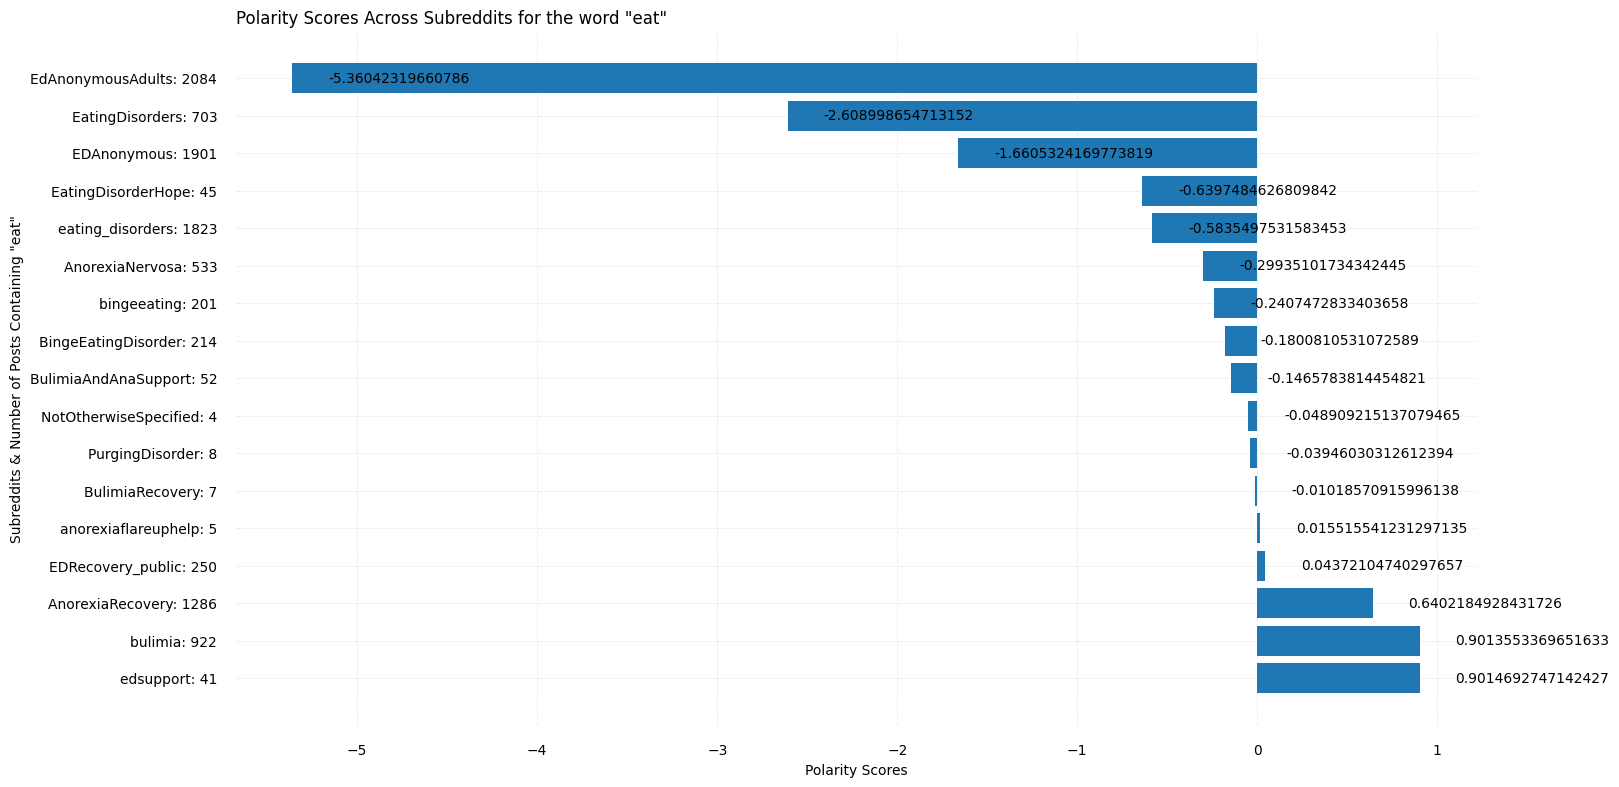

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


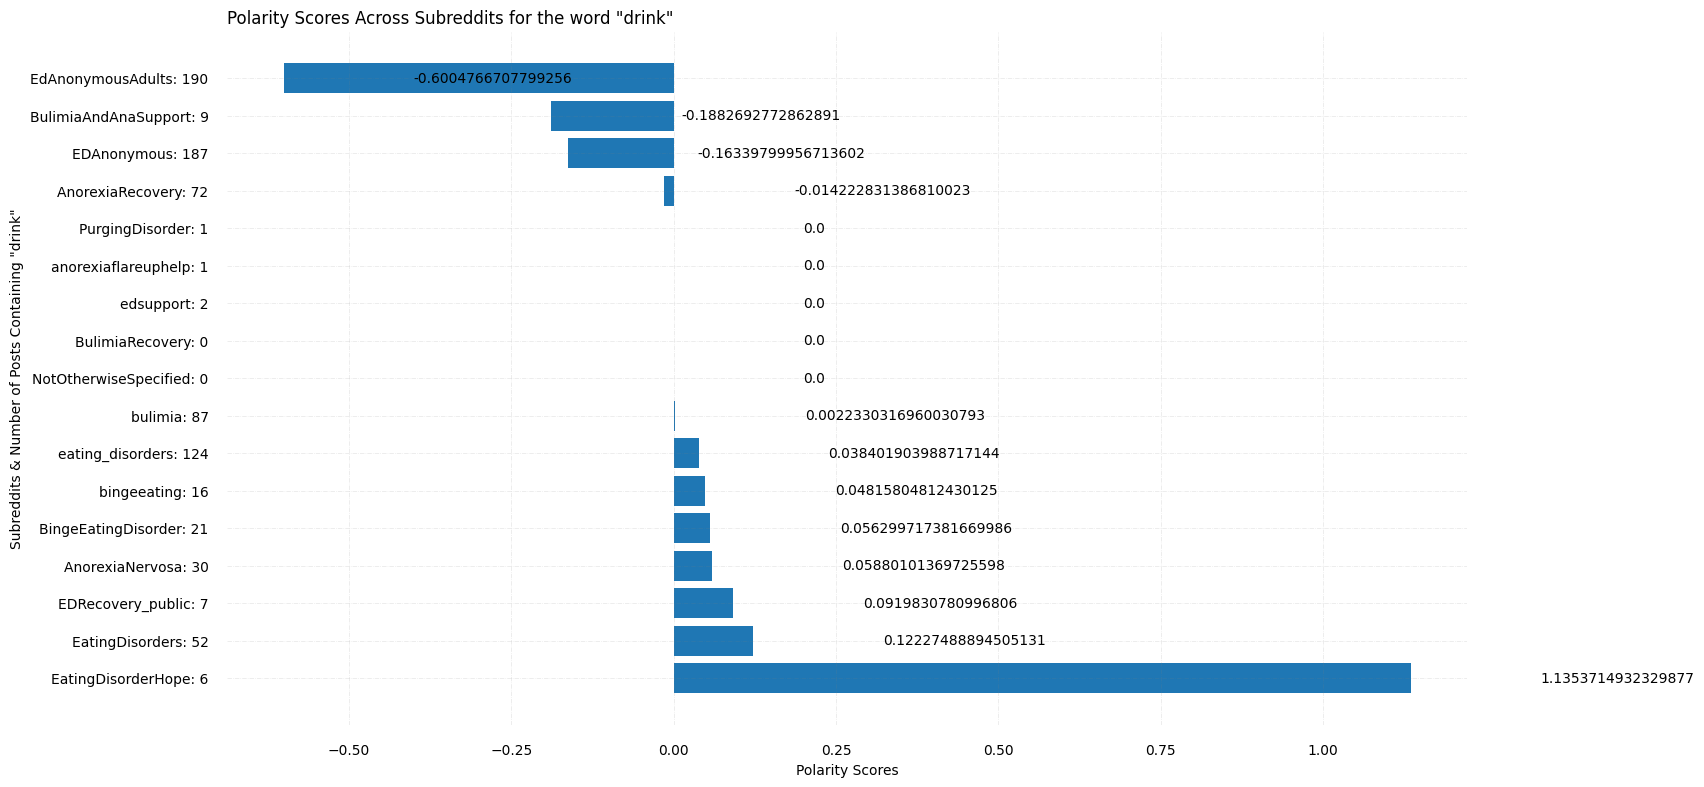

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


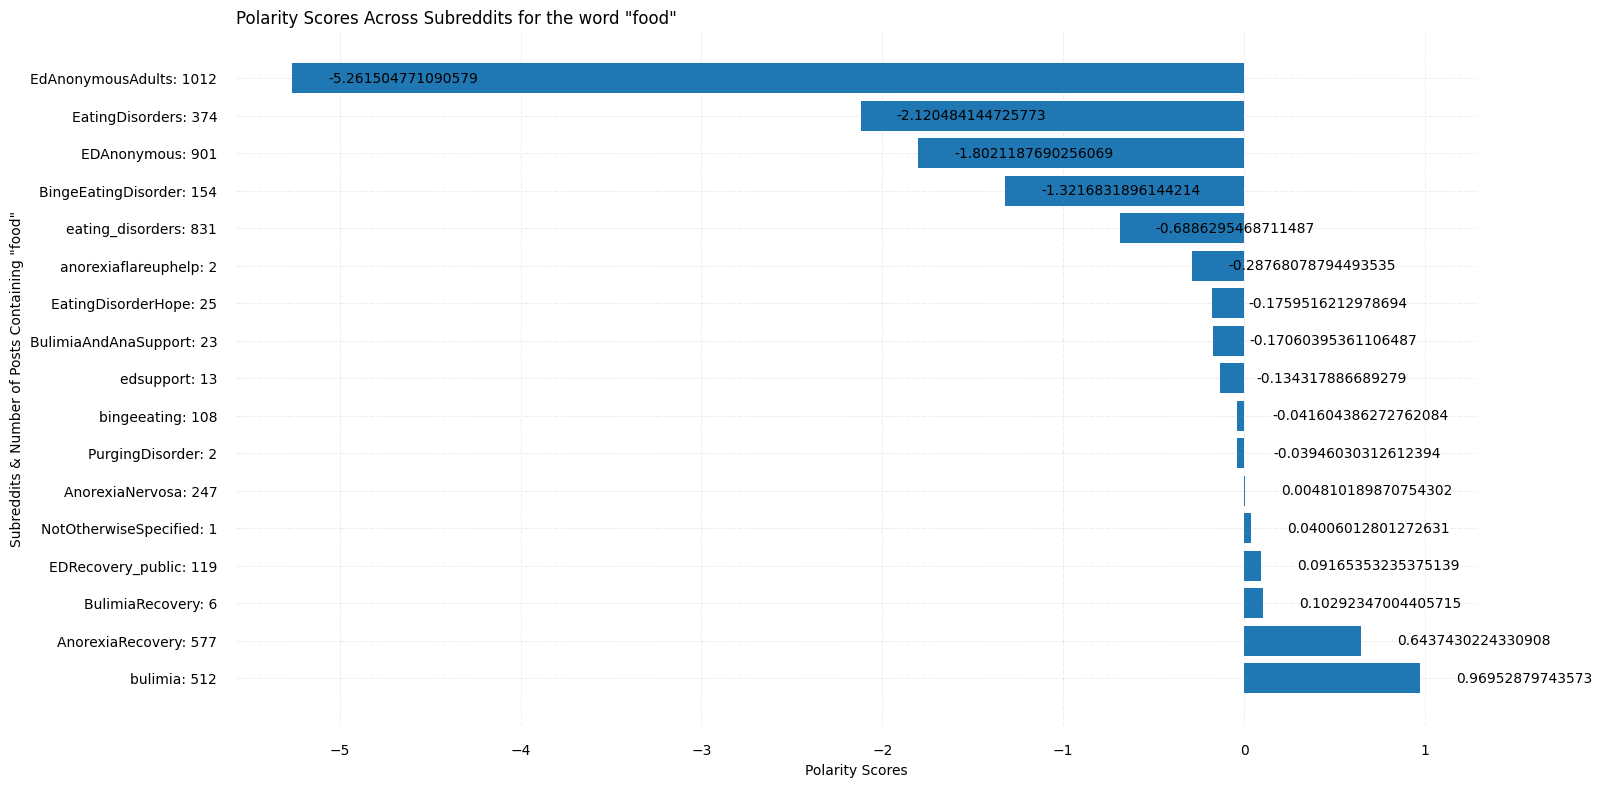

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


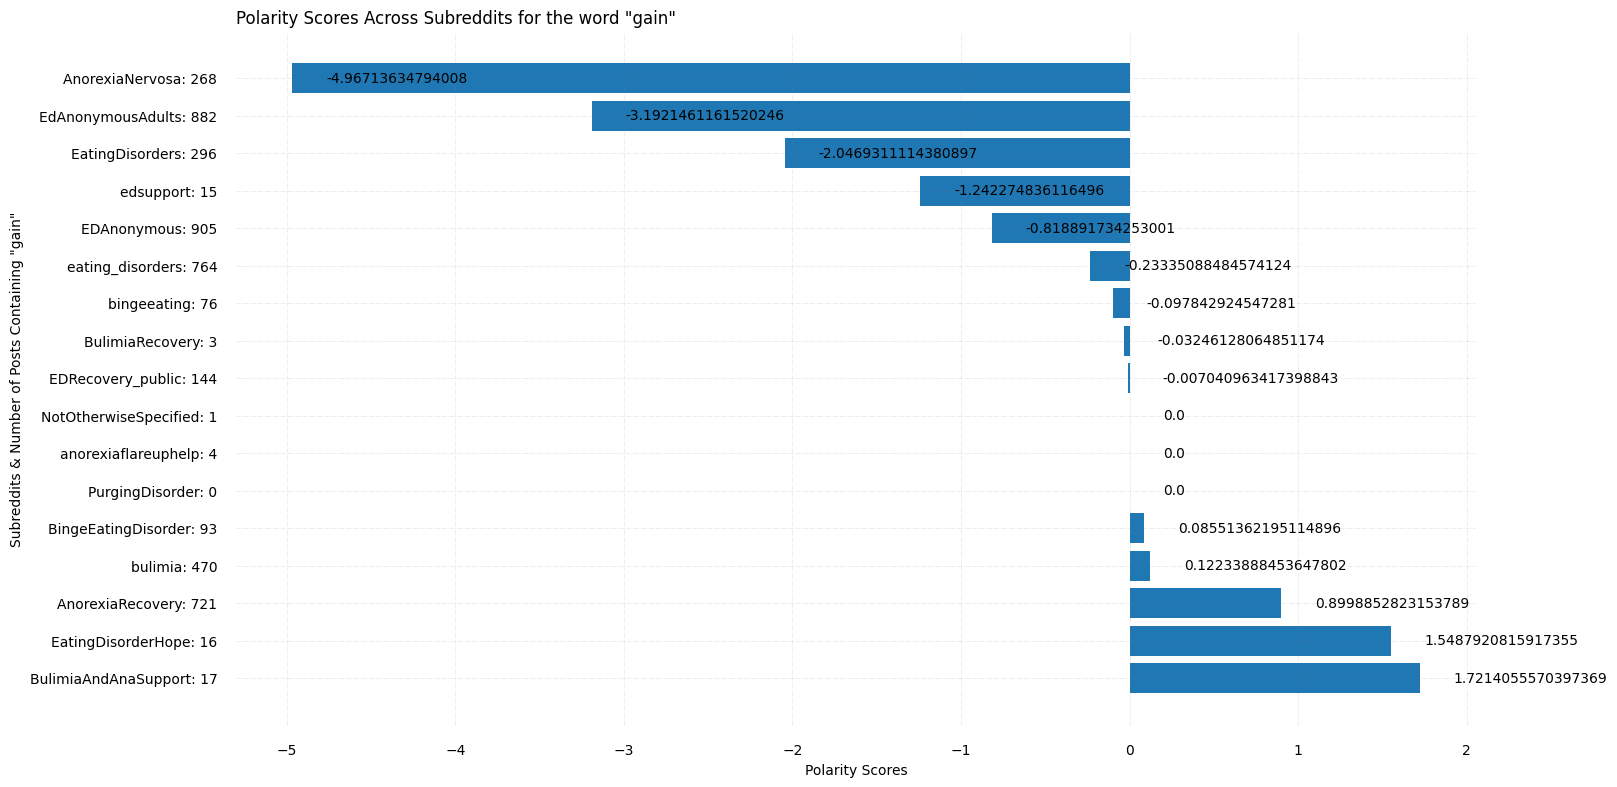

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


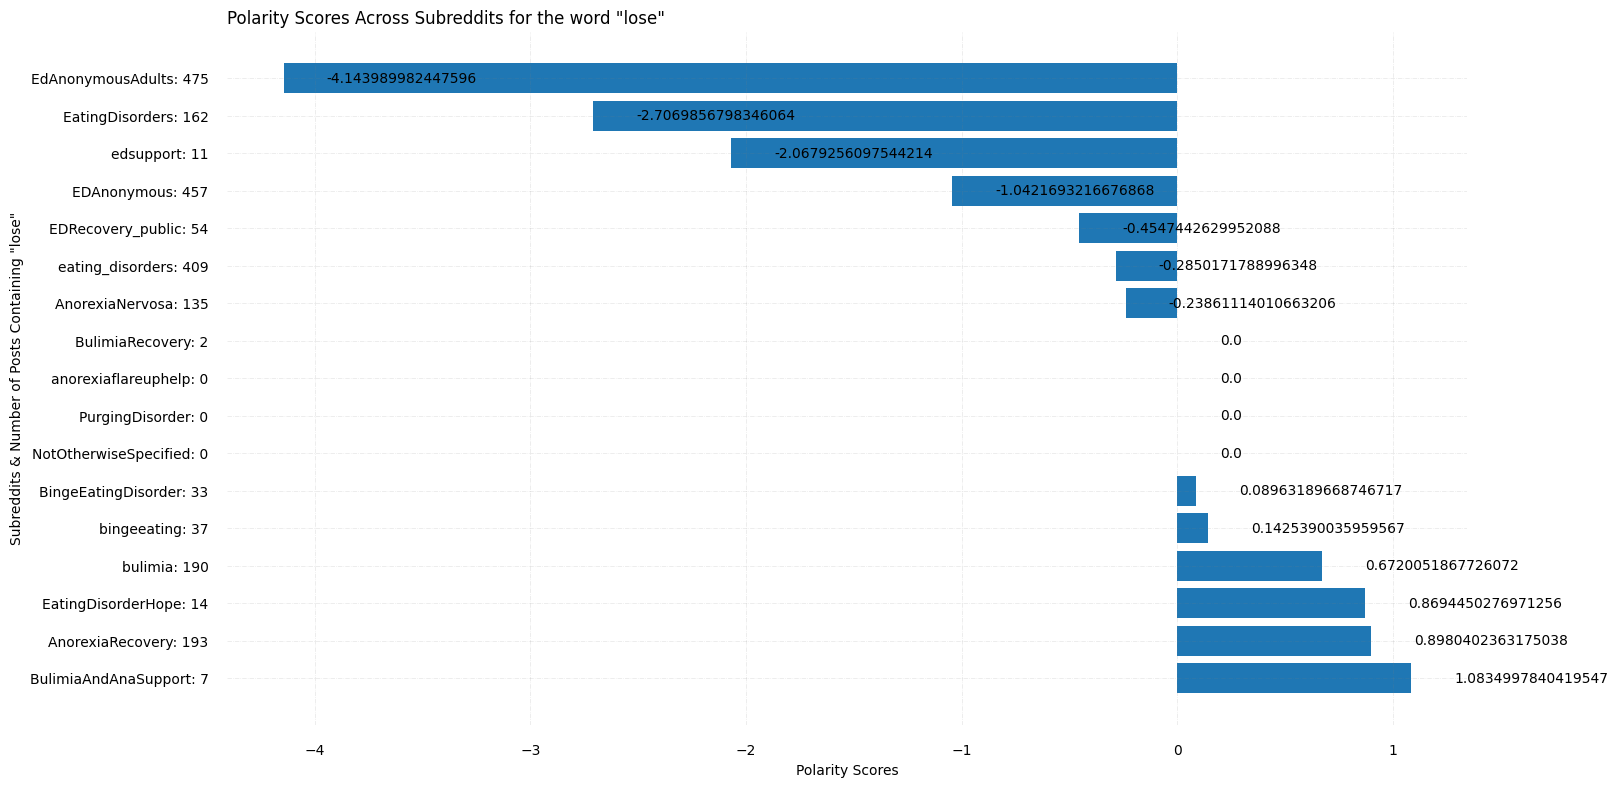

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


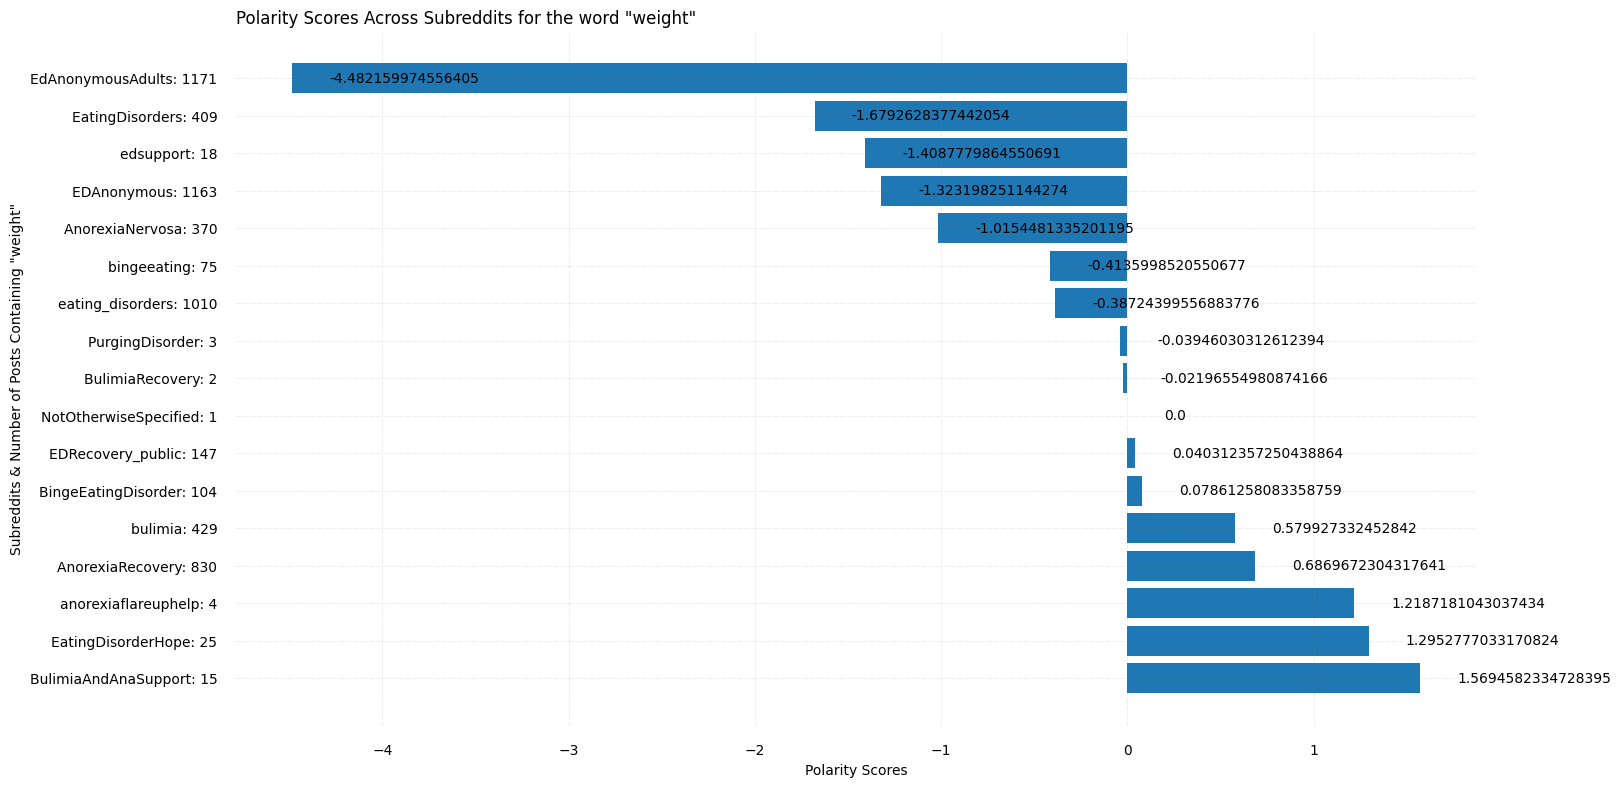

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


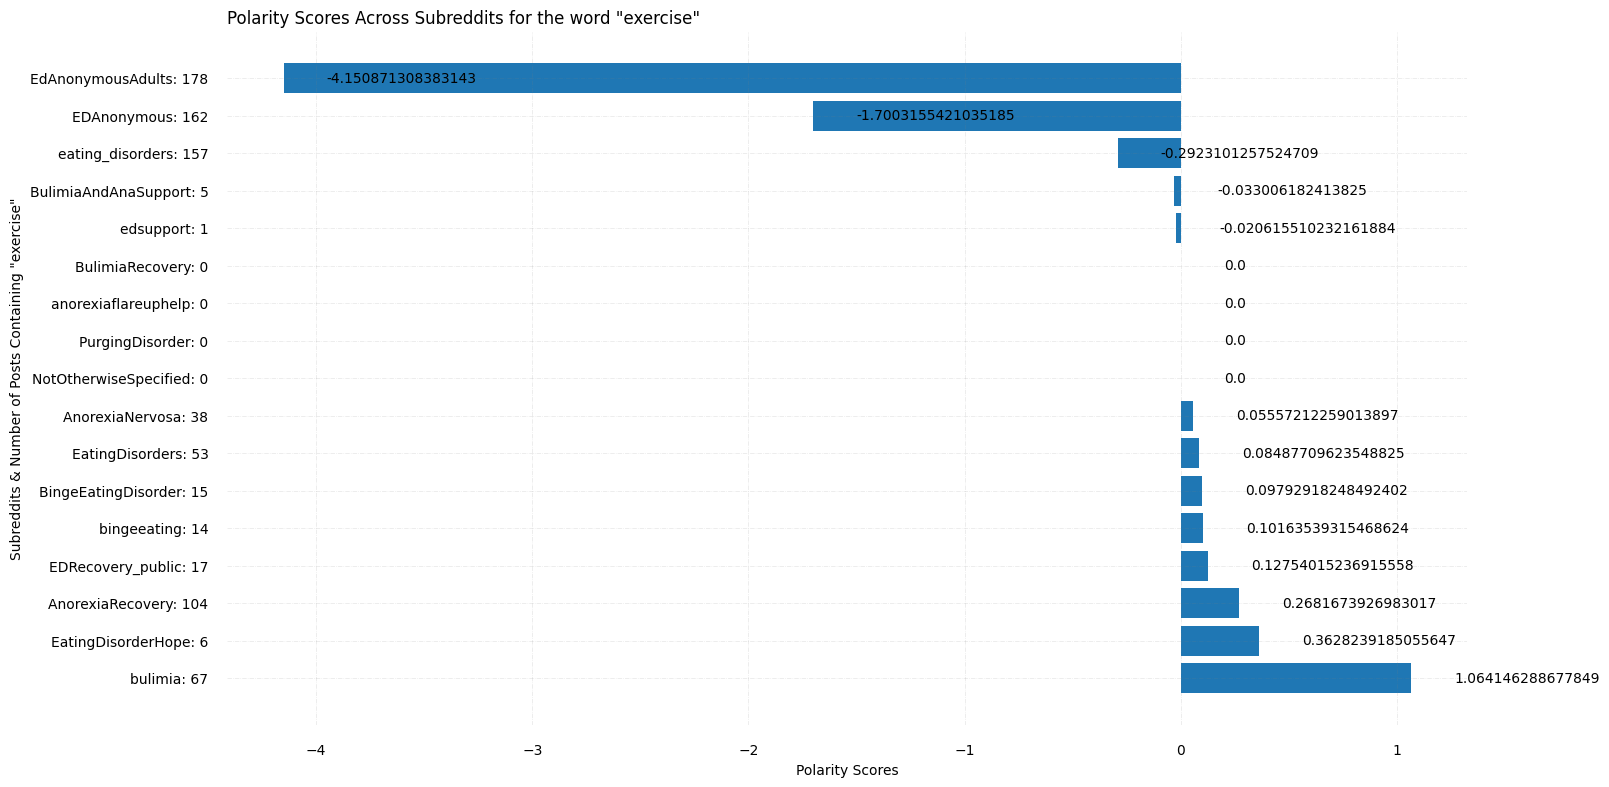

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


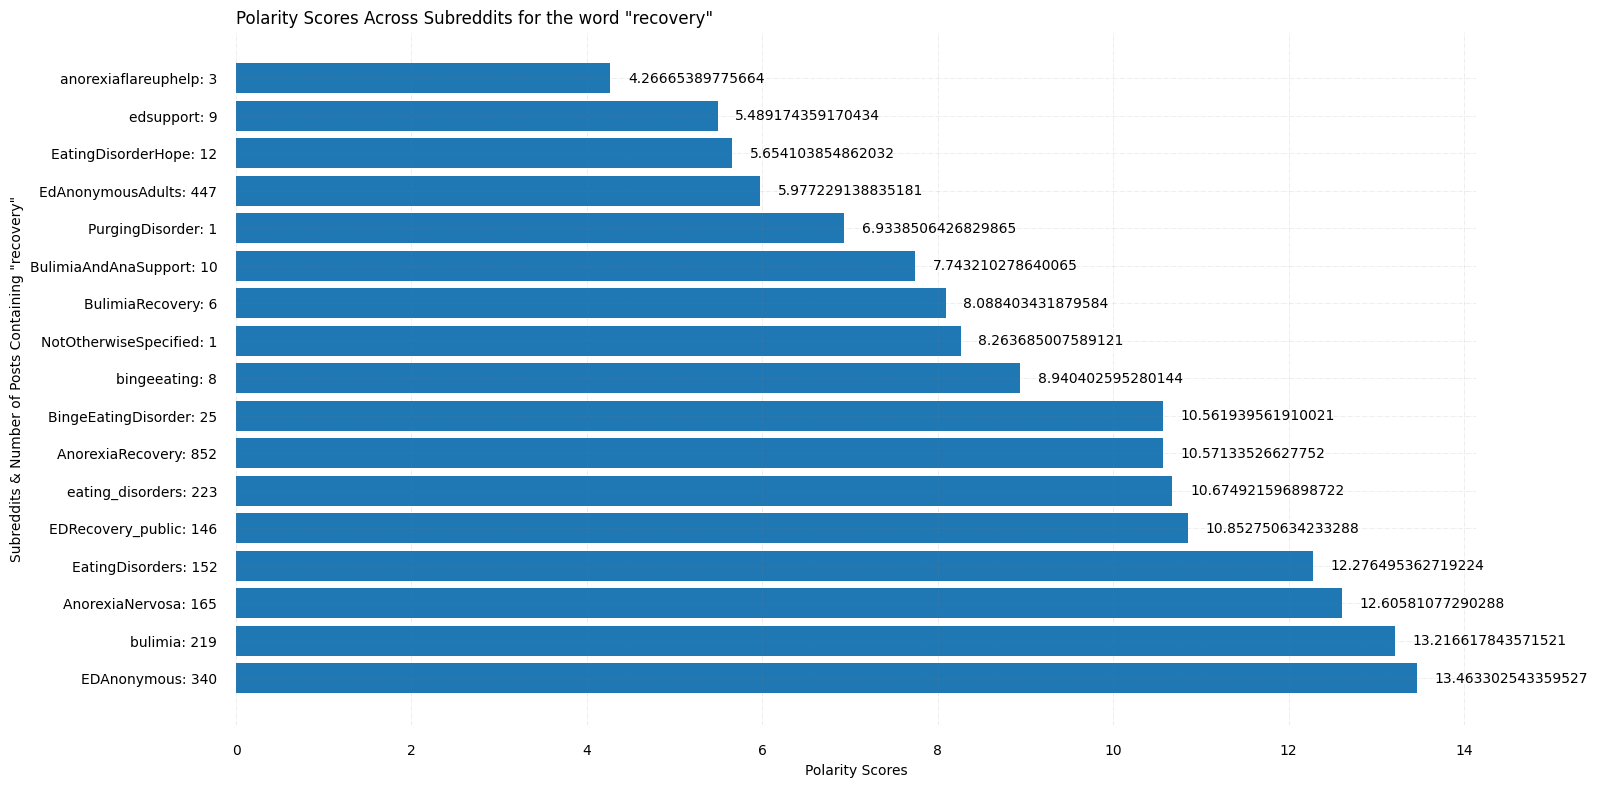

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


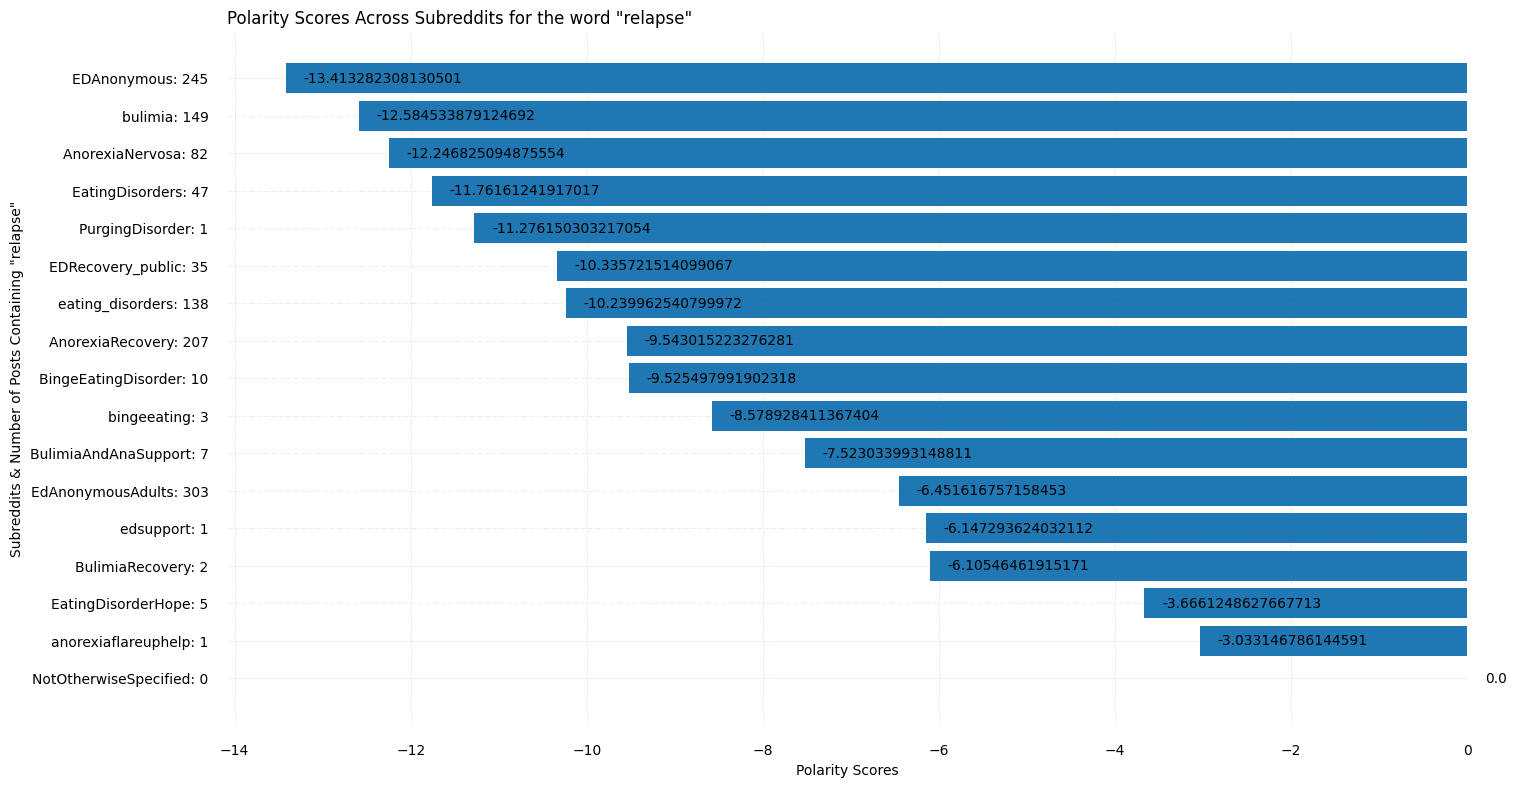

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


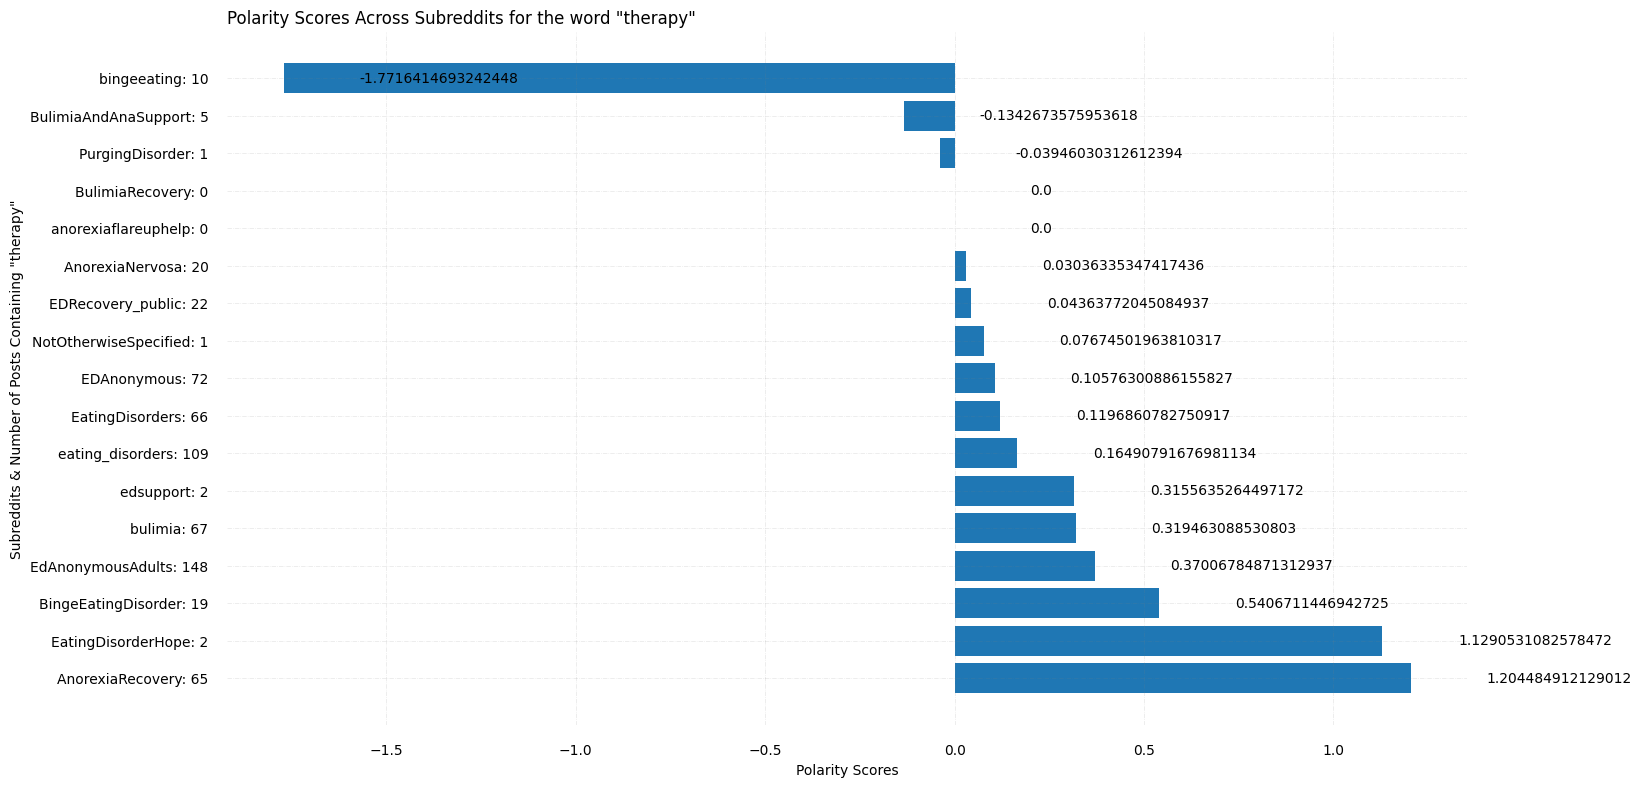

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


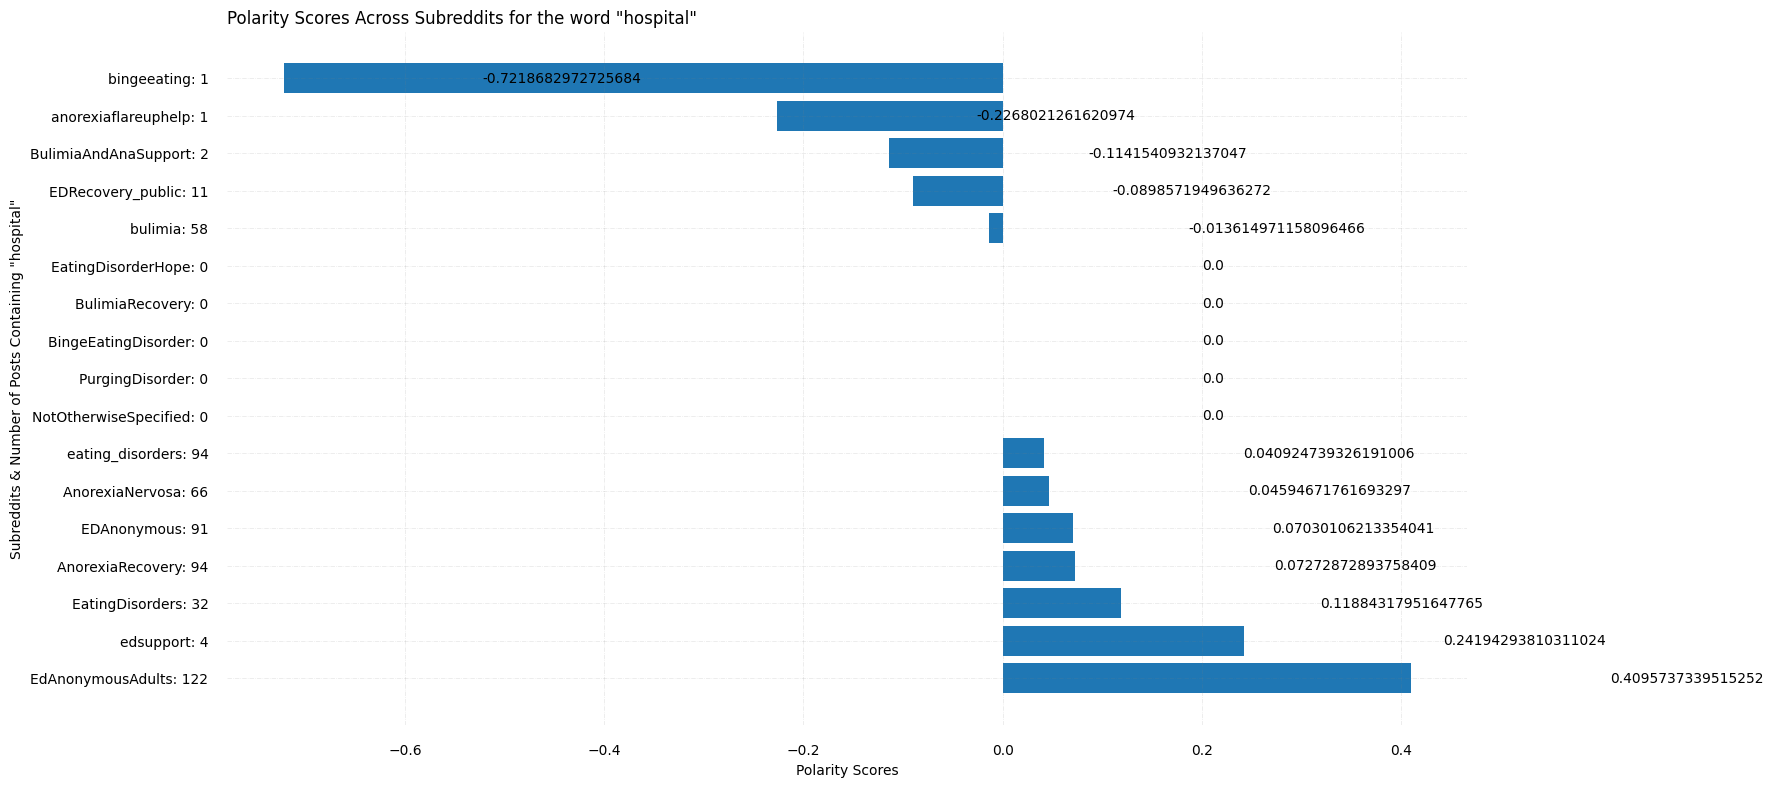

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


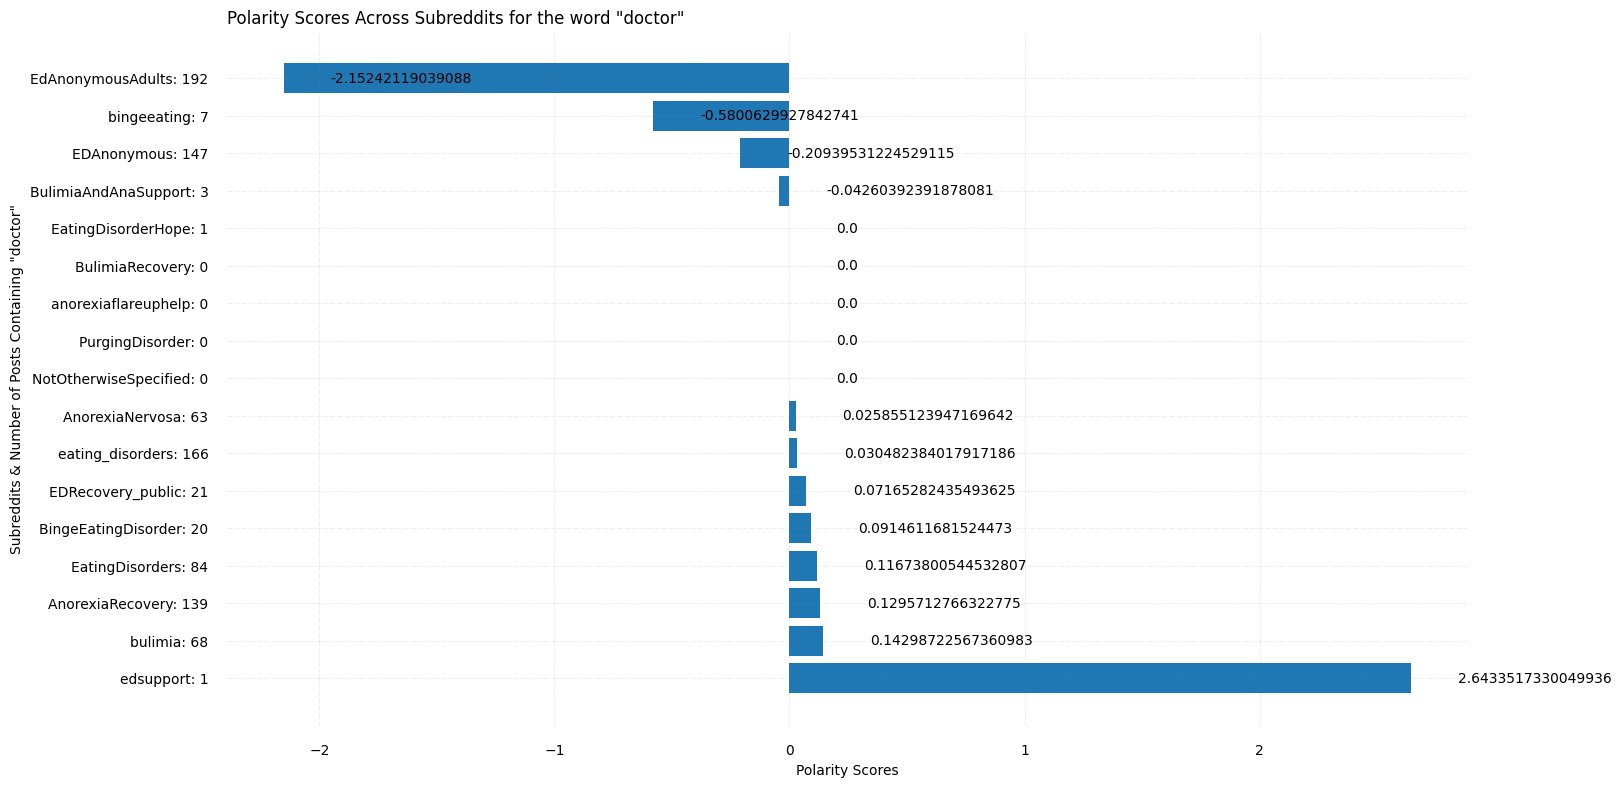

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


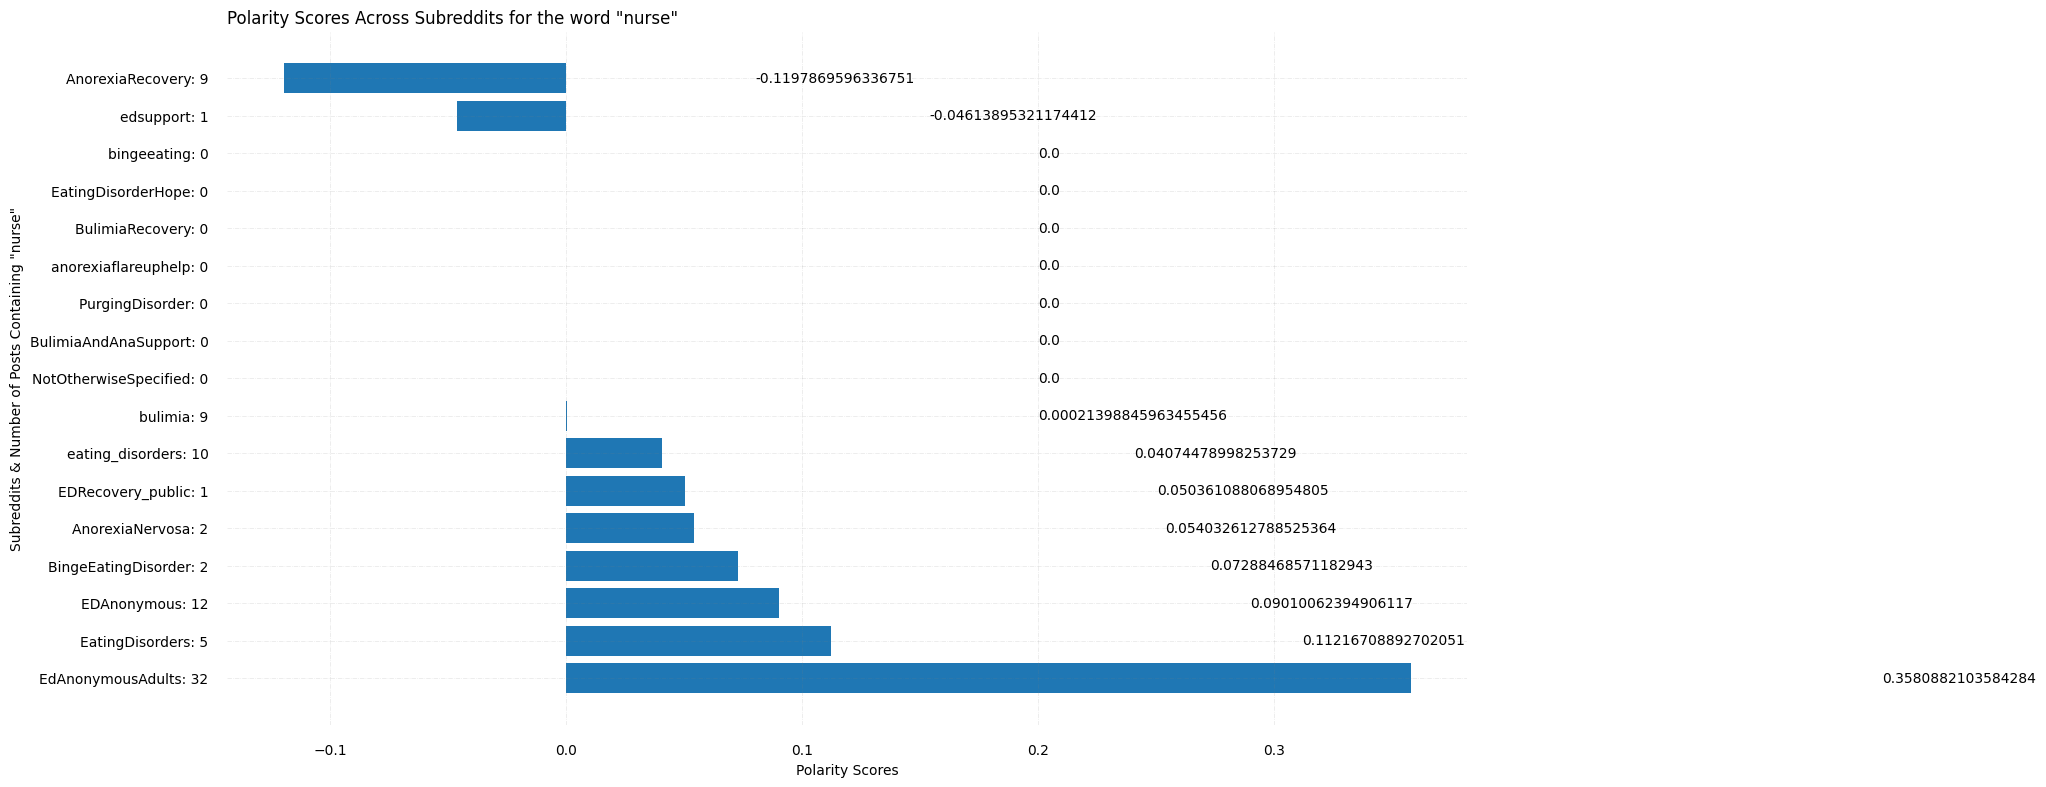

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


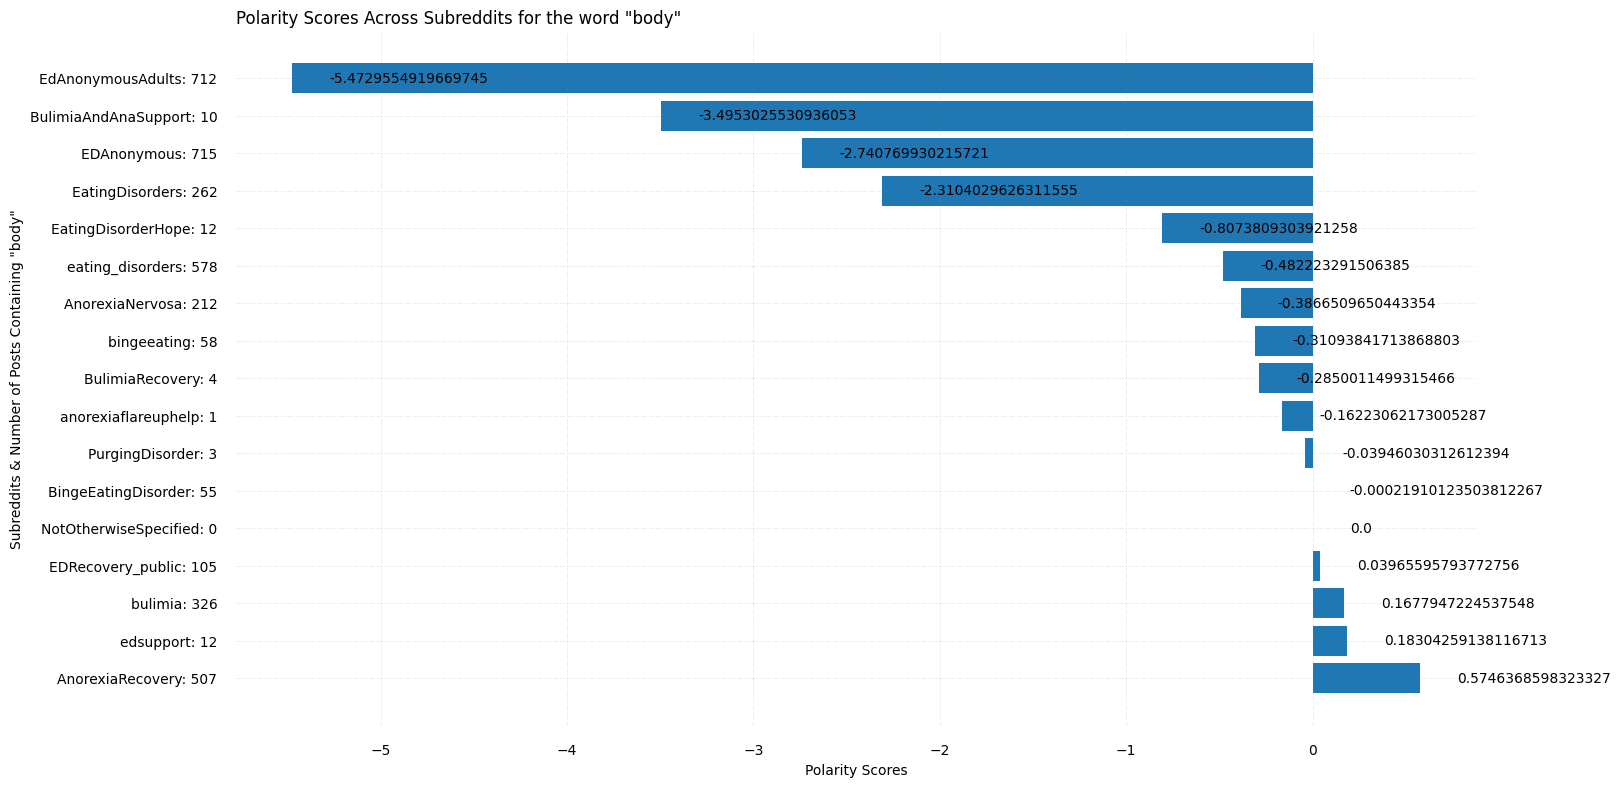

/var/folders/8k/55l2xx0965qbmhwx8xd_1lh00000gs/T/ipykernel_7996/3917590130.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


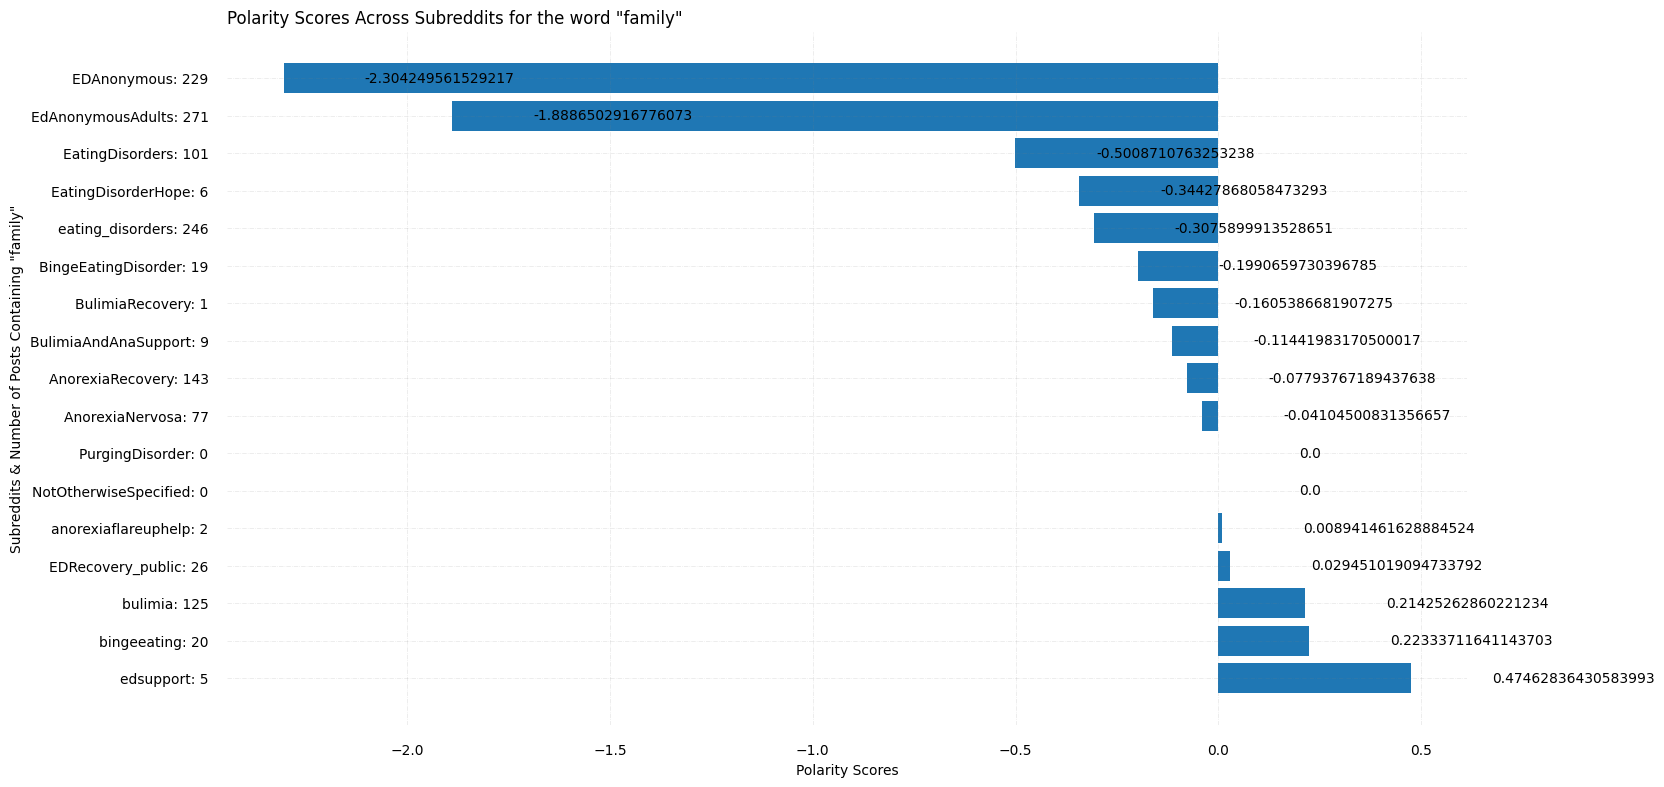

In [15]:
for keyword in keyword_scores.keys():
    subreddits = list(keyword_scores[keyword].keys())
    polarities = list(keyword_scores[keyword].values())

    
    # Figure Size
    fig, ax = plt.subplots(figsize =(16, 9))

    # Horizontal Bar Plot
    ax.barh(subreddits, polarities)

    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax.spines[s].set_visible(False)

    # Remove x, y Ticks
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')

    # Add padding between axes and labels
    ax.xaxis.set_tick_params(pad = 10)
    ax.yaxis.set_tick_params(pad = 10)

    # Add x, y gridlines
    ax.grid(b = True, color ='grey',
            linestyle ='-.', linewidth = 0.5,
            alpha = 0.2)

    # Show top values
    ax.invert_yaxis()

    # Add annotation to bars
#     for i in ax.patches:
#         plt.text(i.get_width()+0.2, i.get_y()+0.5,
#                  str(round((i.get_width()), 2)),
#                  fontsize = 10,
#                  color ='black')
    for i in ax.patches:
        plt.text(i.get_width()+0.2, i.get_y()+0.5,
                 str(i.get_width()),
                 fontsize = 10,
                 color ='black')

    # Add Plot Title
    ax.set_title(f'Polarity Scores Across Subreddits for the word "{keyword}"',
                 loc ='left', )
    plt.ylabel(f'Subreddits & Number of Posts Containing "{keyword}"')
    plt.xlabel("Polarity Scores")

    # Show Plot
    plt.show()
